In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Tue Nov  4 12:45:14 PST 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# NOTE: This notebook was designed for the baseline scenario only

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.5/united_states_of_america/2025_11_04_08_09_23

In [2]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [69]:
locations = [
            'united_states_of_america',
            #  'brazil',
            #  'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
             'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    'results/model8.5/united_states_of_america/2025_11_04_08_09_23/results/',
    # 'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

artifact_subdirs = ['artifacts/model8.3/' + x + '.hdf' for x in locations]
artifact_dirs = ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_subdir
                 for artifact_subdir in artifact_subdirs]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf']

In [4]:
apath = artifact_dirs[0]
!ls $apath

artifacts/model8.3/united_states_of_america.hdf


In [5]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [6]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [7]:
filters = [('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dirs[0])]
test = pd.read_parquet(results_dirs[0] + 'deaths' + '.parquet', filters=filters)
test['location'] = locations[0]
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf'],
      dtype=object)

In [8]:
[[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_dir)]
                 for artifact_dir in artifact_dirs
                 ]

[[('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf')],
 [('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf')]]

In [70]:
def print_memory_usage(df, label=''):
    """Print the memory usage of a dataframe in megabytes."""
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB', label)

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

def load_df(measure):
    # data = pd.DataFrame()
    dfs_by_location = []
    data_all = pd.read_parquet(
        results_dirs[0] + measure + '.parquet',
        # Combine location filters with OR using disjunctive normal form
        filters=[[('artifact_path', '==', artifact_dir)]
                 for artifact_dir in artifact_dirs
                 ],
    )
    print_memory_usage(data_all, 'for parquet file loaded into memory')
    convert_to_categorical(data_all, inplace=True)
    print_memory_usage(data_all, 'after converting to categorical')
    # Loop through unique locations (artifact paths), and aggregate
    # random seeds for each one, then concatenate
    for location, artifact in zip(locations, artifact_dirs):
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols, observed=True)['value'].sum().reset_index()
        
        temp['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        # data = pd.concat([data, temp], ignore_index=True)
        dfs_by_location.append(temp)
    data = pd.concat(dfs_by_location, ignore_index=True)
    print_memory_usage(data, 'after aggregating seeds')
    convert_to_categorical(data, exclude_cols=['event_year'], inplace=True)
    print_memory_usage(data, 'after converting aggregated data to categoricals')
    return data

In [72]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
# person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

7646.815192 MB for parquet file loaded into memory
319.962308 MB after converting to categorical
313.556173 MB after aggregating seeds
86.391925 MB after converting aggregated data to categoricals


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199495,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,24,0.0,sweden
3199496,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,41,0.0,sweden
3199497,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,177,0.0,sweden
3199498,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,sweden


In [73]:
person_time.location.unique()

['united_states_of_america', 'sweden']
Categories (2, object): ['sweden', 'united_states_of_america']

In [74]:
person_time.memory_usage(deep=True)

Index                 132
measure           3199676
entity_type       3199670
entity            3199703
sub_entity        3199883
age_group         3201030
event_year       25596000
sex               3199732
treatment         3200492
artifact_path     3199926
scenario          3199673
input_draw        3200256
value            25596000
location          3199752
dtype: int64

In [75]:
person_time.dtypes

measure          category
entity_type      category
entity           category
sub_entity       category
age_group        category
event_year          int64
sex              category
treatment        category
artifact_path    category
scenario         category
input_draw       category
value             float64
location         category
dtype: object

In [76]:
# This is insane -- 45 GB!
print_memory_usage(person_time)

86.391925 MB 


In [77]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [78]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        3.579189e+08
alzheimers_disease_state                      2.221054e+08
alzheimers_mild_cognitive_impairment_state    1.625696e+08
Name: value, dtype: float64

In [79]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
sweden                   2022       25_to_29                                 0.000000   
                                    30_to_34                                 0.000000   
                                    35_to_39                                 0.000000   
                                    40_to_44                               430.521561   
                                    45_to_49                              7084.670773   
...                                                                               ...   
united_states_of_america 2100       75_to_79                            514891.329227   
                                    80_to_84                            645627.373032   
                                    85_to_89                            489970.907598   
                                    90_to_94                            212225.204654   
                                    95_plus                              59709.952088   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
sweden                   2022       25_to_29                   0.000000   
                                    30_to_34                   0.000000   
                                    35_to_39                   0.000000   
                                    40_to_44                   0.498289   
                                    45_to_49                1200.876112   
...                                                                 ...   
united_states_of_america 2100       75_to_79              244812.796715   
                                    80_to_84              368426.798084   
                                    85_to_89              395912.908966   
                                    90_to_94              247630.121834   
                                    95_plus                89821.546886   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
sweden                   2022       25_to_29                                     0.000000  
                                    30_to_34                                     0.000000  
                                    35_to_39                                     0.000000  
                                    40_to_44                                     0.000000  
                                    45_to_49                                  2131.679671  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                195989.459274  
                                    80_to_84                                277813.470226  
                                    85_to_89                                274360.328542  
                                    90_to_94                                147821.869952  
                                    95_plus                                  50891.734428  

[2370 rows x 3 columns]

In [80]:
#assert np.all(person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [81]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

5151.205185 MB for parquet file loaded into memory
213.312306 MB after converting to categorical
209.039171 MB after aggregating seeds
57.596423 MB after converting aggregated data to categoricals


0.0

In [82]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [83]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [84]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

In [85]:
out_counts

alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
sweden                   2022       25_to_29                                      0.0   
                                    30_to_34                                      0.0   
                                    35_to_39                                      0.0   
                                    40_to_44                                     45.0   
                                    45_to_49                                   1008.0   
...                                                                               ...   
united_states_of_america 2100       75_to_79                                  75228.0   
                                    80_to_84                                  95679.0   
                                    85_to_89                                  75258.0   
                                    90_to_94                                  32457.0   
                                    95_plus                                    8938.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
sweden                   2022       25_to_29                                          0.0  
                                    30_to_34                                          0.0  
                                    35_to_39                                          0.0  
                                    40_to_44                                          0.0  
                                    45_to_49                                        504.0  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                      50060.0  
                                    80_to_84                                      70540.0  
                                    85_to_89                                      67811.0  
                                    90_to_94                                      35113.0  
                                    95_plus                                       11318.0  

[2370 rows x 2 columns]

In [86]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

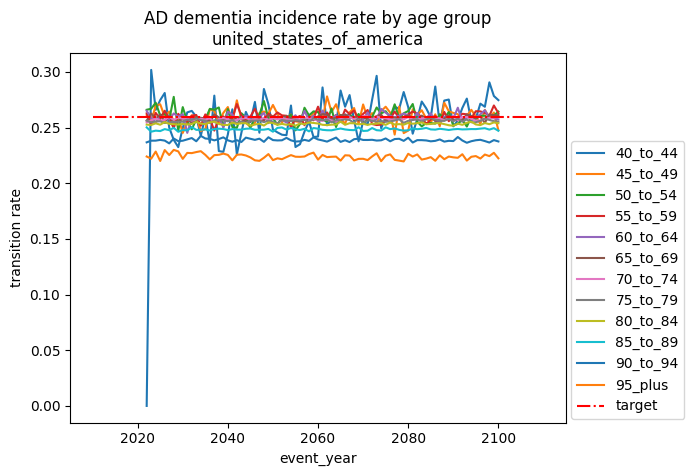

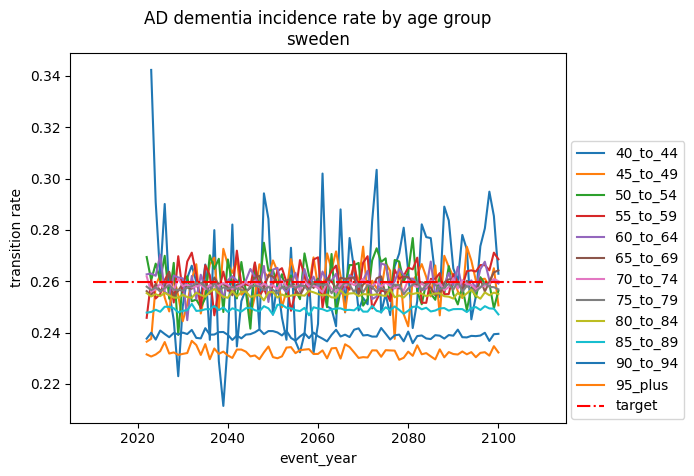

In [149]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    # .iloc[:,3:] filters out the first 3 age groups, which have 0 or
    # very few people
    t.loc[location].iloc[:,3:].plot(ylabel='transition rate')
    plt.title(f"AD dementia incidence rate by age group\n{location}")
    plt.hlines(1/3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [141]:
1 / 3.85

0.2597402597402597

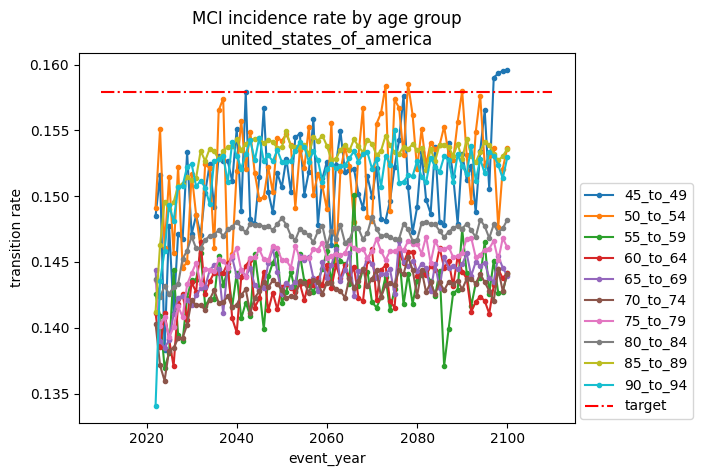

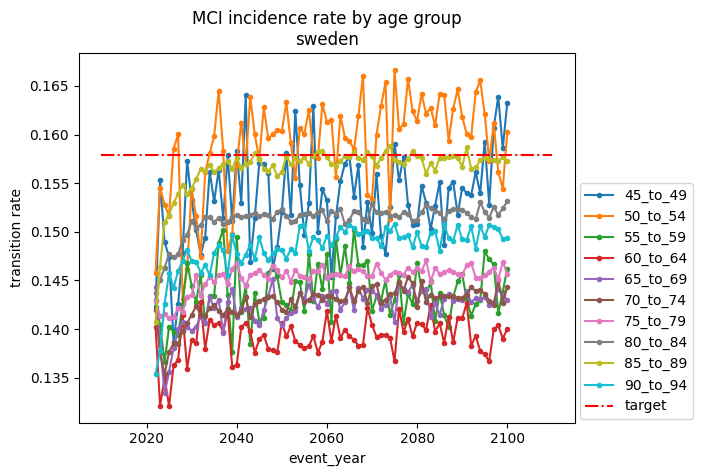

In [150]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.', ylabel='transition rate')
    plt.title(location)
    plt.title(f"MCI incidence rate by age group\n{location}")
    # target is 1 / mean of Weibull distribution
    plt.hlines(0.15791673988674756, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [89]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

# Load counts of new simulants

In [90]:
new_sims = load_df('counts_new_simulants')
new_sims.head()

148.726317 MB for parquet file loaded into memory
8.897884 MB after converting to categorical
11.023749 MB after aggregating seeds
2.610501 MB after converting aggregated data to categoricals


,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location
0,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america
1,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america
2,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america
3,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america
4,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america


In [91]:
new_sims_by_year_and_age = new_sims.groupby(['location', 'event_year', 'age_group', ]).value.sum()

bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims_by_year_and_age
)
#bbbm_duration_est

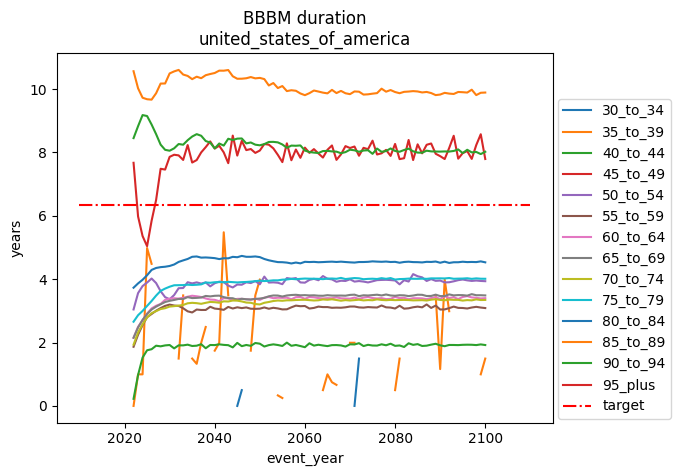

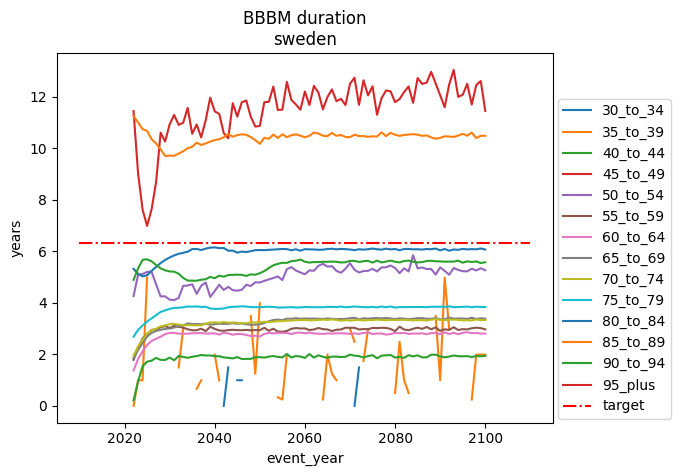

In [156]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    # Target is mean of Weibull distribution
    plt.hlines(6.332450889735727, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'BBBM duration\n{location}')
    plt.legend(loc=(1.01, .01))

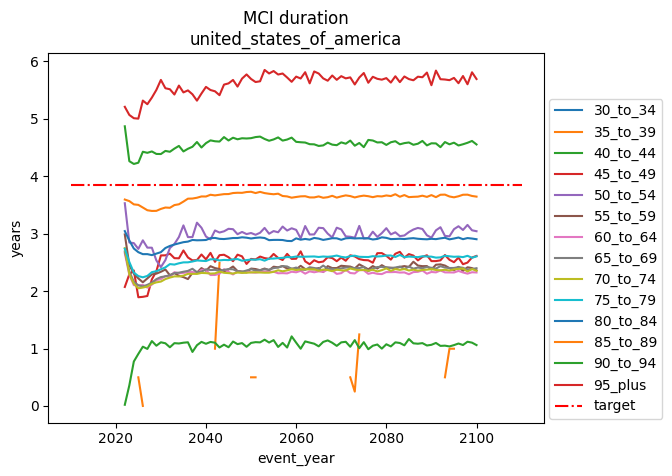

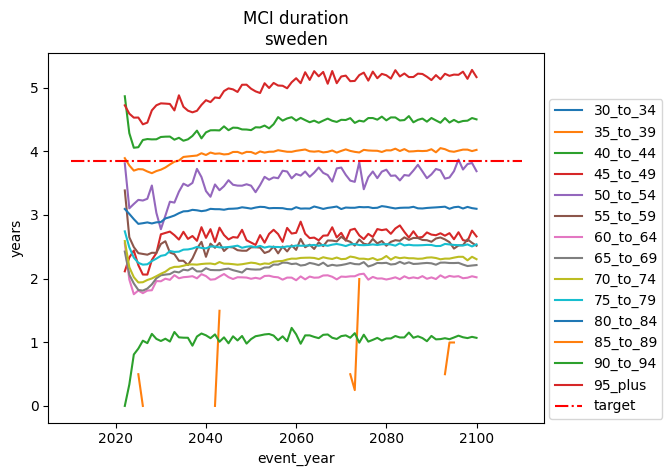

In [153]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    plt.hlines(3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'MCI duration\n{location}')
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [94]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

# Load deaths dataframe
deaths = load_df('deaths')

def calculate_ocmr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time.groupby(cols).sum(numeric_only=True)

    # deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr(person_time, deaths)

375.654503 MB for parquet file loaded into memory
22.526241 MB after converting to categorical
22.993106 MB after aggregating seeds
6.166358 MB after converting aggregated data to categoricals
CPU times: user 18.8 s, sys: 330 ms, total: 19.2 s
Wall time: 18.5 s


In [95]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [96]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [97]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


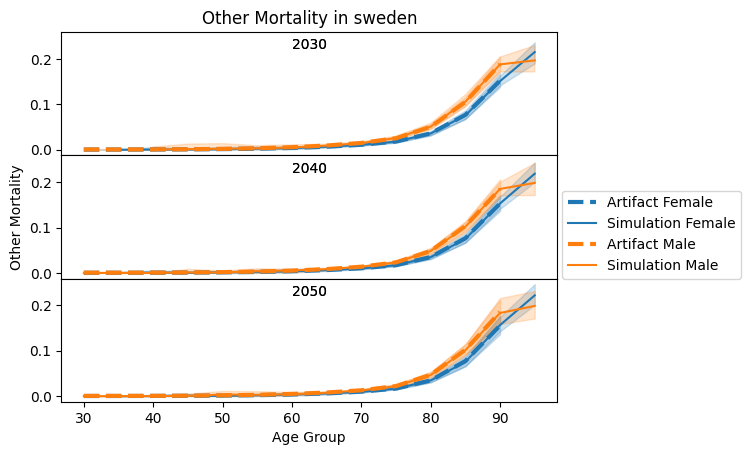

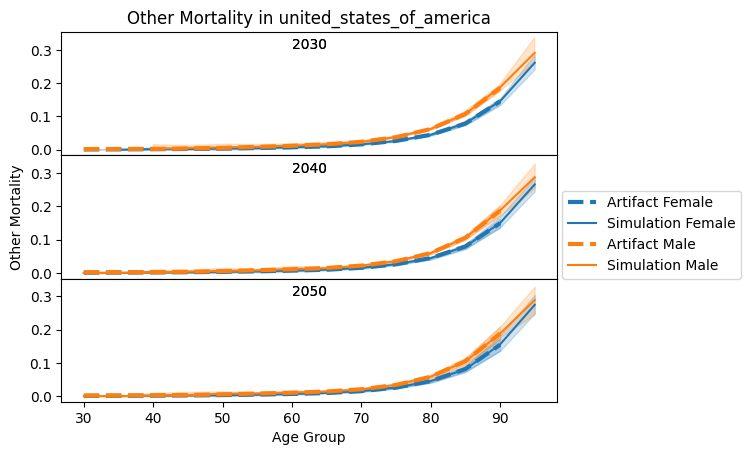

In [98]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [99]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

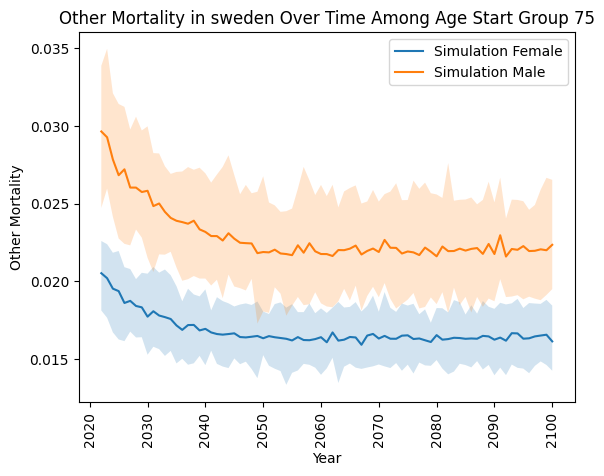

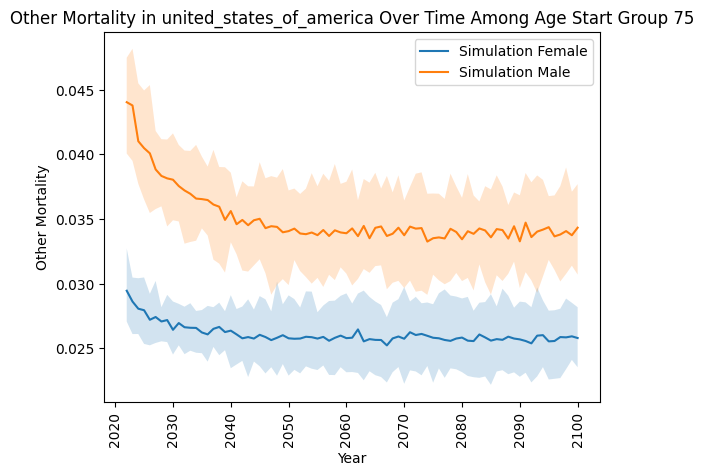

<Figure size 640x480 with 0 Axes>

In [100]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [101]:
cols = ['input_draw','event_year','location','age_group','sex']

def calculate_emr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time.loc[
        person_time.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    # deaths0 = load_df('deaths')
    deaths = deaths.loc[
        deaths.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr(person_time, deaths)

In [102]:
def load_artifact_cause_data(measure, year_start=2025):
    # out = pd.DataFrame()
    artifact_data = []
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = [f'year_start=={year_start}'])
        data = art.load(f'cause.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        # out = pd.concat([out, data])
        artifact_data.append(data)
    out = pd.concat(artifact_data)
    return out

In [103]:
print(art)

Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [157]:
art_emr = load_artifact_cause_data('alzheimers_consistent.excess_mortality_rate')
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Male,30,35,2025,2026,7.936454e-09,2.238392e-10,2.352777e-08,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate,united_states_of_america
1,Female,30,35,2025,2026,8.095870e-09,4.123460e-10,2.228134e-08,11,30 to 34,30_to_34,alzheimers_consistent.excess_mortality_rate,united_states_of_america
2,Male,35,40,2025,2026,7.503084e-09,2.474884e-10,2.138320e-08,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate,united_states_of_america
3,Female,35,40,2025,2026,8.138804e-09,1.584946e-10,2.261747e-08,12,35 to 39,35_to_39,alzheimers_consistent.excess_mortality_rate,united_states_of_america
4,Male,40,45,2025,2026,4.672178e-03,3.371834e-03,5.948665e-03,13,40 to 44,40_to_44,alzheimers_consistent.excess_mortality_rate,united_states_of_america


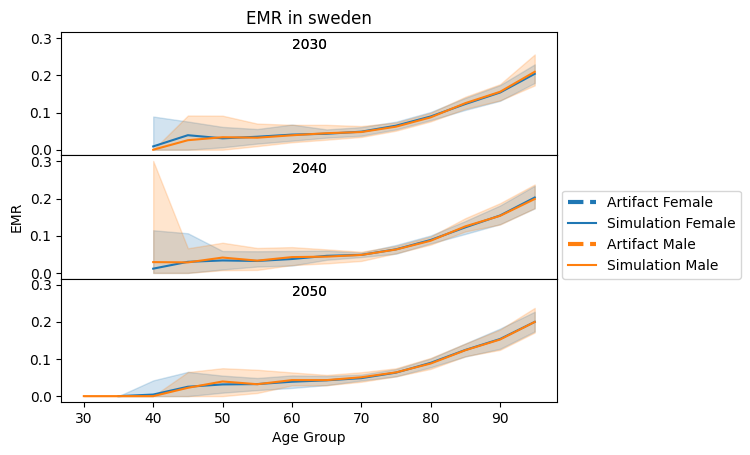

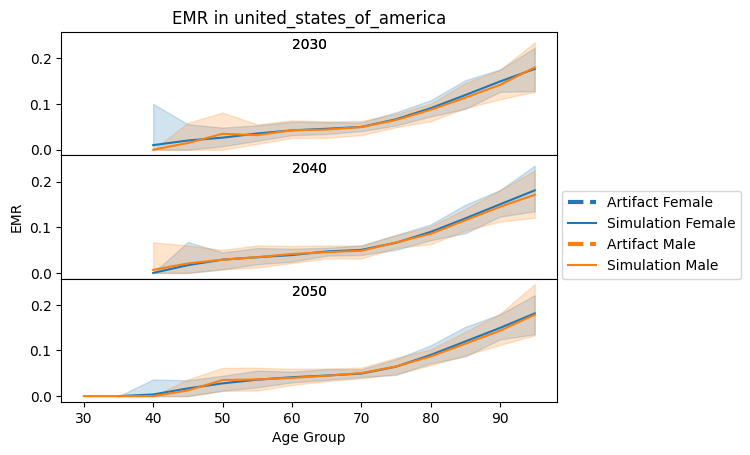

In [105]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

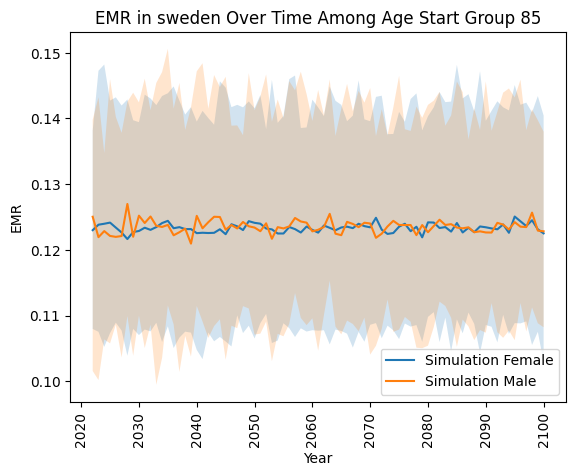

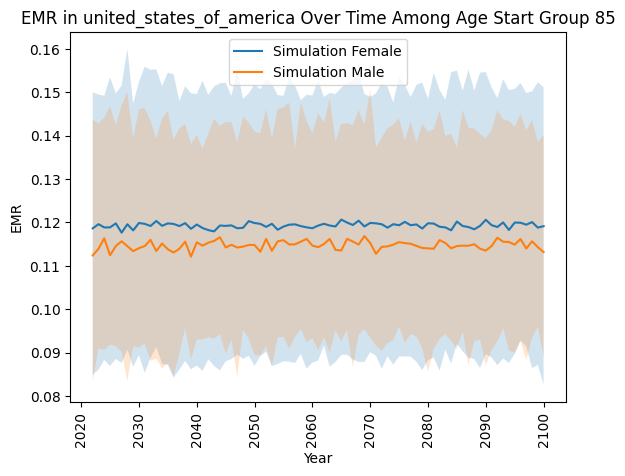

<Figure size 640x480 with 0 Axes>

In [106]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [107]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0      draw_1  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      461.406537  319.465040   
                                2047       2048      461.645918  320.228636   
                                2048       2049      461.766743  319.628891   
                                2049       2050      461.039293  318.401967   
                                2050       2051      459.674681  317.997717   

                                                         draw_2      draw_3  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      345.850380  475.536198   
                                2047       2048      346.981314  480.201154   
                                2048       2049      347.808807  482.591205   
                                2049       2050      348.654607  484.359780   
                                2050       2051      349.174960  487.758215   

                                                         draw_4      draw_5  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      294.635186  563.721700   
                                2047       2048      293.091065  573.600344   
                                2048       2049      291.022294  581.484096   
                                2049       2050      288.500000  587.722977   
                                2050       2051      285.525602  593.935178   

                                                         draw_6      draw_7  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      278.472513  291.455040   
                                2047       2048      279.954070  294.484785   
                                2048       2049      280.036472  297.198244   
                                2049       2050      279.229648  301.019002   
                                2050       2051      278.351226  305.286646   

                                                         draw_8      draw_9  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      411.199012  352.714939   
                                2047       2048      411.306755  353.823737   
                                2048       2049      410.670434  354.310969   
                                2049       2050      410.152284  354.871704   
                                2050       2051      410.610137  355.604404   

                                                     ...    draw_490  \
sex  age_start age_end location year_start year_end  ...               
Male 95.0      125.0   Sweden   2046       2047      ...  319.131152   
                                2047       2048      ...  320.821642   
                                2048       2049      ...  322.412459   
                                2049       2050      ...  324.692741   
                                2050       2051      ...  326.802525   

                                                       draw_491    draw_492  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      479.426780  557.849017   
                                2047       2048      489.176995  565.677839   
                                2048       2049      496.595444  572.740649   
                                2049       2050      502.898835  579.325302   
                                2050       2051      509.320407  585.735812   

                                                       draw_493    draw_494  \
sex  age_start age_end location year_start year_end                           
Male 95.0      125.0   Sweden   2046       2047      294.328271  508.4

In [108]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2025"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.02068399173333995
0.6246007133337842


In [109]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
sweden,168.0,0.124920,0.000000e+00,0.124920,0.124920,0.124920,0.124920,0.124920
united_states_of_america,168.0,0.004137,6.943028e-19,0.004137,0.004137,0.004137,0.004137,0.004137


In [110]:
# new_sims = load_df('counts_new_simulants')
new_sims.head()

,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location
0,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america
1,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america
2,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america
3,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america
4,25_to_29,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america


In [111]:
# trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
533250,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america
533251,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america
533252,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america
533253,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america
533254,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,24,0.0,sweden
2132996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,41,0.0,sweden
2132997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,177,0.0,sweden
2132998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,sweden


In [112]:
new_sims_with_scale = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [113]:
new_ad_dementia

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location,ratio
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america,0.020684
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america,0.020684
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america,0.020684
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america,0.020684
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america,0.020684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365395,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,24,0.0,sweden,0.624601
365396,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,41,0.0,sweden,0.624601
365397,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,177,0.0,sweden,0.624601
365398,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,sweden,0.624601


In [114]:
new_sims_with_scale

,age_group,event_year,sex,artifact_path,scenario,input_draw,value,location,ratio
0,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america,0.020684
1,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america,0.020684
2,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america,0.020684
3,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america,0.020684
4,30_to_34,2022,Female,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america,0.020684
...,...,...,...,...,...,...,...,...,...
40595,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,24,0.0,sweden,0.624601
40596,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,41,0.0,sweden,0.624601
40597,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,177,0.0,sweden,0.624601
40598,95_plus,2050,Male,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,sweden,0.624601


In [115]:
cols = ['input_draw','event_year','location','age_group','sex']

new_sims_with_scale['total_incidence'] = new_sims_with_scale['value'] / new_sims_with_scale['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_ad_dementia['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims_with_scale)

In [116]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2022,sweden,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
1,2022,sweden,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
2,2022,united_states_of_america,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
3,2022,united_states_of_america,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
4,2023,sweden,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,2049,united_states_of_america,95_plus,Male,25.0,5646.879070,949.449121,3625.992553,4032.103719,5511.508681,7522.725884,7638.757646,33,95 to 99,95.0,125.0
1620,2050,sweden,95_plus,Female,25.0,528.145410,84.854613,361.831159,365.673614,539.544693,672.749792,699.646976,33,95 to 99,95.0,125.0
1621,2050,sweden,95_plus,Male,25.0,269.099917,54.350186,174.511488,187.960080,259.365698,364.392795,373.038319,33,95 to 99,95.0,125.0
1622,2050,united_states_of_america,95_plus,Female,25.0,15109.269237,2423.851190,11119.710497,11612.845484,14794.049618,20257.211732,20982.410242,33,95 to 99,95.0,125.0


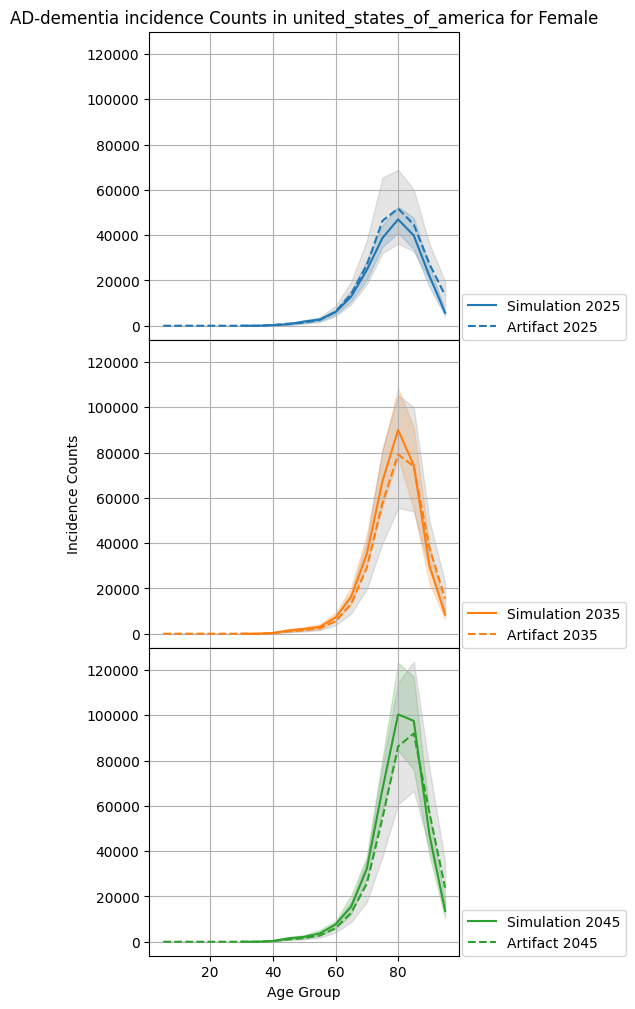

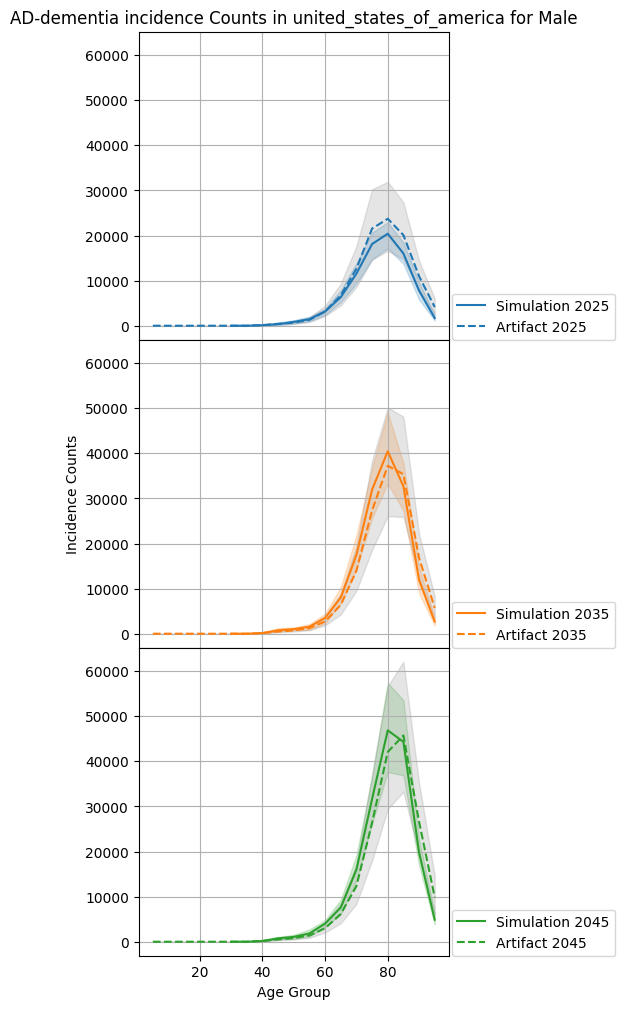

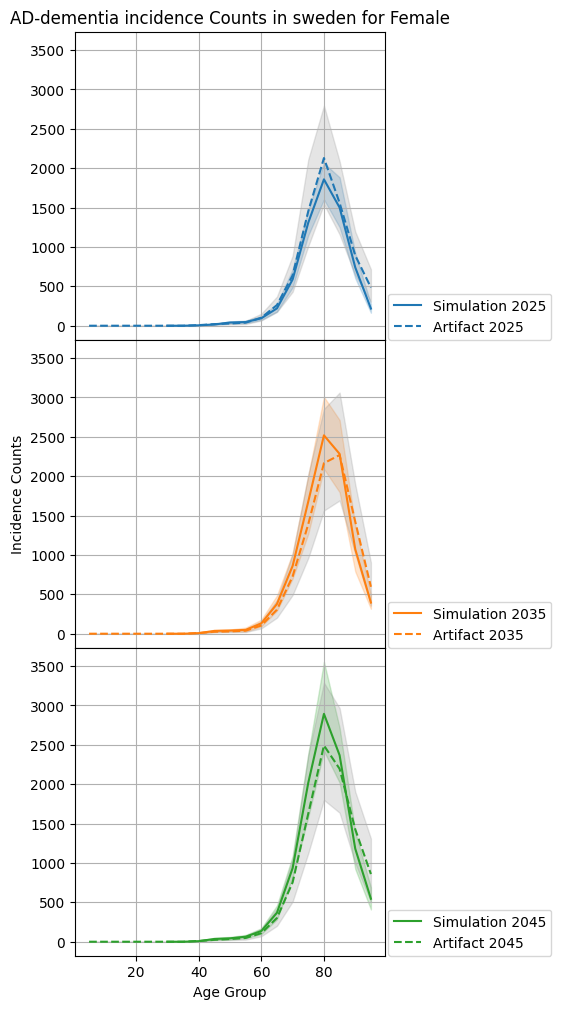

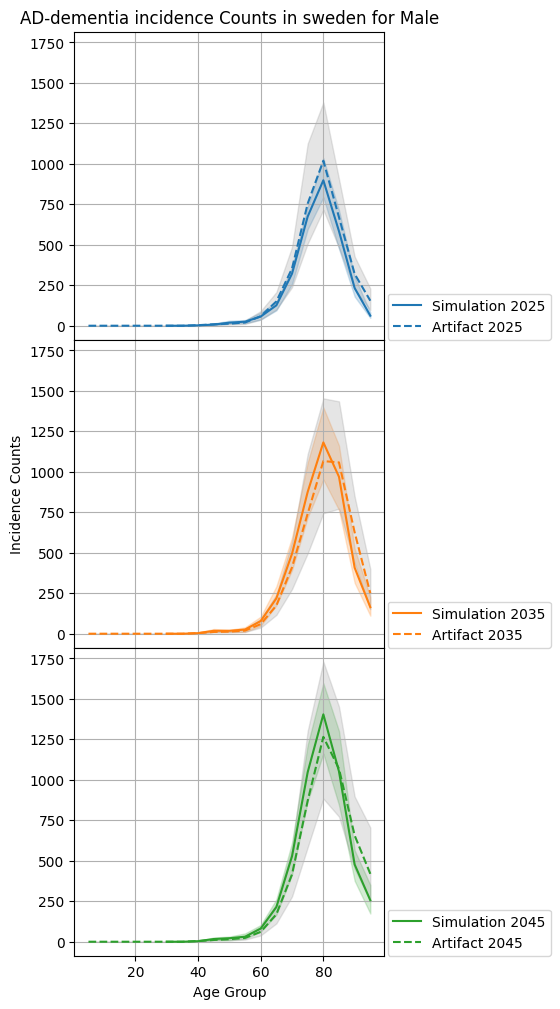

In [117]:
for location in new_sims_with_scale.location.unique():
    for sex in new_sims_with_scale.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and event_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

In [118]:
plot_data

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
93,2045,sweden,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,30 to 34,30.0,35.0
209,2045,sweden,35_to_39,Male,25.0,0.064041,0.320205,0.000000,0.000000,0.000000,0.640409,1.601023,12,35 to 39,35.0,40.0
325,2045,sweden,40_to_44,Male,25.0,3.202046,2.167795,0.000000,0.000000,3.202046,6.404091,6.404091,13,40 to 44,40.0,45.0
441,2045,sweden,45_to_49,Male,25.0,16.650637,5.309992,8.005114,8.965728,14.409205,25.936570,28.818411,14,45 to 49,45.0,50.0
557,2045,sweden,50_to_54,Male,25.0,21.709870,6.537455,8.005114,8.965728,22.414320,31.700252,33.621479,15,50 to 54,50.0,55.0
673,2045,sweden,55_to_59,Male,25.0,30.995802,8.779875,17.611251,18.571865,30.419434,51.232730,56.035799,16,55 to 59,55.0,60.0
789,2045,sweden,60_to_64,Male,25.0,81.267919,11.803857,60.838867,61.799481,81.652164,103.105870,104.066484,17,60 to 64,60.0,65.0
905,2045,sweden,65_to_69,Male,25.0,214.152813,26.930517,137.687963,166.506374,214.537059,261.927335,280.178995,18,65 to 69,65.0,70.0
1021,2045,sweden,70_to_74,Male,25.0,528.017328,55.545725,411.462867,414.344708,533.140601,611.590720,621.196857,19,70 to 74,70.0,75.0
1137,2045,sweden,75_to_79,Male,25.0,1047.197011,112.481511,861.350281,868.074577,1039.063815,1215.816735,1216.777349,20,75 to 79,75.0,80.0


## Verifying Prevalence

In [119]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [120]:
# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
# new_sims.sub_entity.unique()
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [121]:
cols = ['input_draw','event_year','location','age_group','sex']

# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_dementia = person_time.loc[person_time.sub_entity == 'alzheimers_disease_state']
person_time_dementia = person_time_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])
person_time_dementia['total_prev'] = person_time_dementia['value'] / person_time_dementia['ratio']
person_time_dementia = person_time_dementia.groupby(cols).sum(numeric_only=True)
person_time_dementia = person_time_dementia.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

person_time_dementia = person_time_dementia.merge(age_dictionary, on=['age_group'])
person_time_dementia = person_time_dementia.loc[person_time_dementia['age_group_id'].isin(age_group_ids)]
person_time_dementia.tail()

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
1619,2049,united_states_of_america,95_plus,Male,25.0,41932.983890,4482.919829,32498.158877,33105.240866,43025.731471,48489.469375,48735.193038,33,95 to 99,95.0,125.0
1620,2050,sweden,95_plus,Female,25.0,3672.494673,415.223693,2845.652056,2952.393924,3615.501855,4416.305200,4548.894876,33,95 to 99,95.0,125.0
1621,2050,sweden,95_plus,Male,25.0,1589.161451,252.592748,1127.251571,1145.440769,1582.779276,2037.030546,2102.128726,33,95 to 99,95.0,125.0
1622,2050,united_states_of_america,95_plus,Female,25.0,121387.489213,16457.588999,91351.385071,96063.497655,121030.948997,148826.631511,149795.071828,33,95 to 99,95.0,125.0
1623,2050,united_states_of_america,95_plus,Male,25.0,43065.239981,4893.817456,33365.418862,34189.315847,44615.708109,50204.716901,50349.260232,33,95 to 99,95.0,125.0


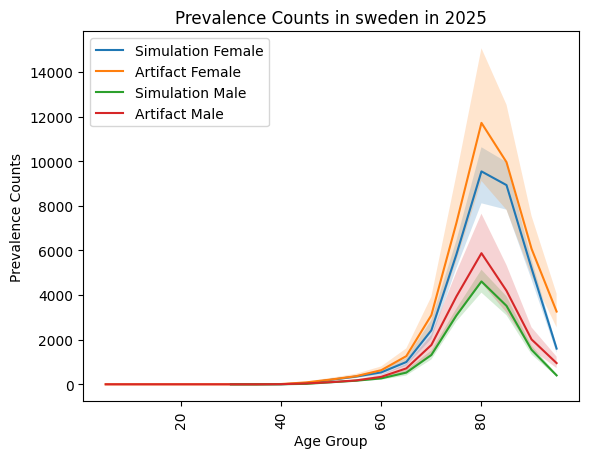

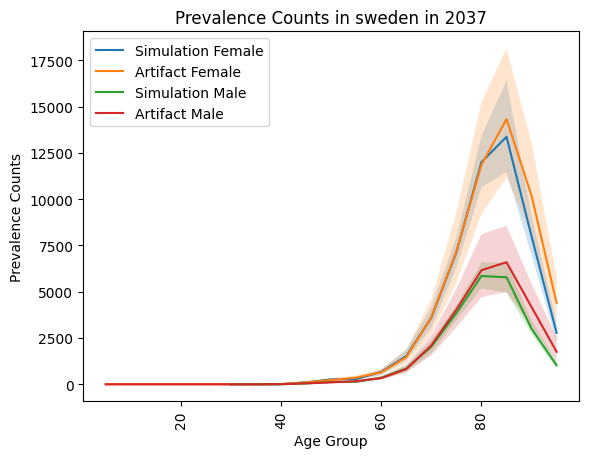

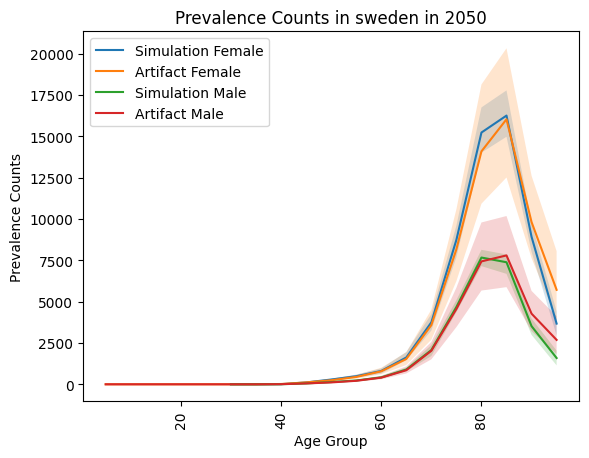

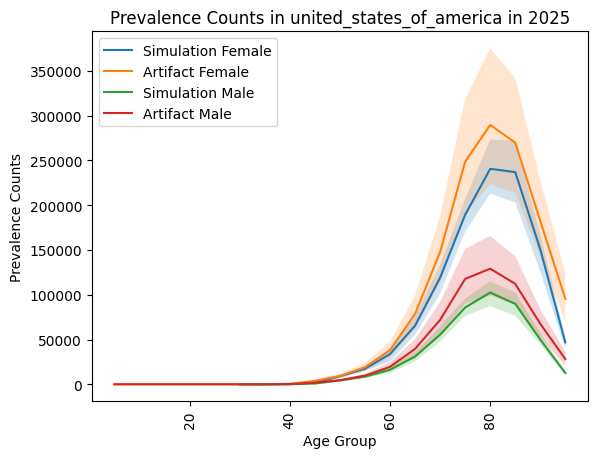

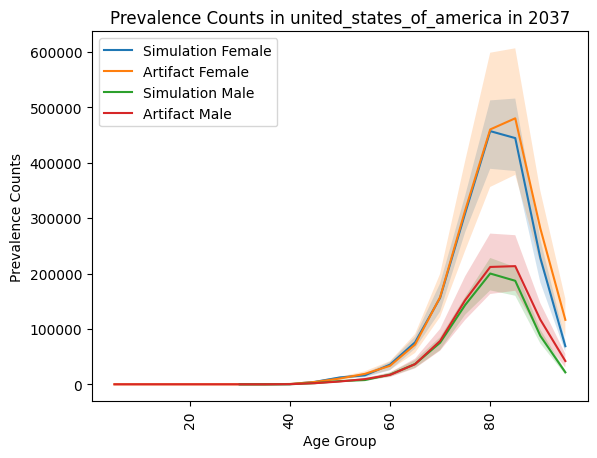

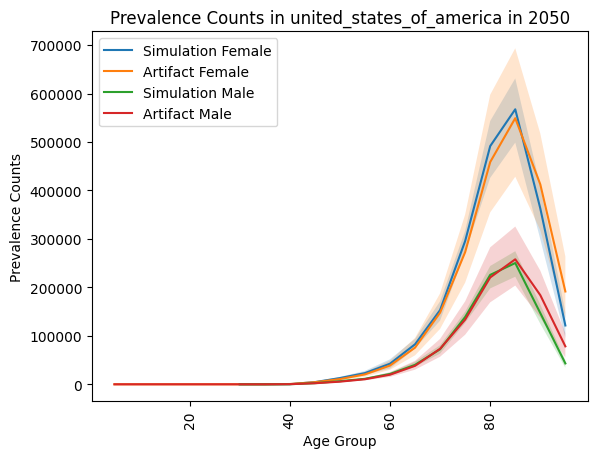

<Figure size 640x480 with 0 Axes>

In [122]:
for location in person_time_dementia.location.unique():
    for year in [2025,2037,2050]:
        for sex in person_time_dementia.sex.unique(): # [:1]:
            plot_data = person_time_dementia.loc[(person_time_dementia.location == location) & (person_time_dementia.event_year == year) & (person_time_dementia.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [123]:
cols = ['input_draw','event_year','location'] #, 'age_group']

# # FIXME: Don't reload person-time
# person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,sweden,25.0,100961.252402,107.291698,100806.822724,100808.018617,100937.374401,101167.683504,101223.890486
1,2022,united_states_of_america,25.0,101111.994743,62.917736,100949.831622,101012.317043,101101.311431,101227.378508,101243.822040
2,2023,sweden,25.0,106023.906913,519.739588,105349.722108,105378.124572,105941.190965,106938.466256,107514.288843
3,2023,united_states_of_america,25.0,106845.126790,252.902203,106239.167693,106370.715948,106804.227242,107323.244901,107340.884326
4,2024,sweden,25.0,111089.690678,820.535103,109984.306639,110014.502943,110934.543463,112569.030527,113593.911020


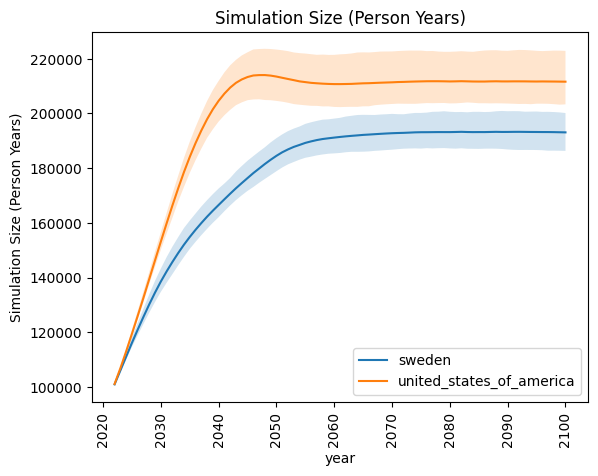

In [124]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()

# Decompose person-time by state

In [125]:
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,158,0.0,united_states_of_america
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,323,0.0,united_states_of_america
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,2,0.0,united_states_of_america
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,united_states_of_america
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2022,Female,susceptible_to_treatment,/mnt/team/simulation_science/pub/models/vivari...,baseline,317,0.0,united_states_of_america
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199495,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,24,0.0,sweden
3199496,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,41,0.0,sweden
3199497,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,177,0.0,sweden
3199498,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2100,Male,no_effect_never_treated,/mnt/team/simulation_science/pub/models/vivari...,baseline,392,0.0,sweden


In [126]:
cols = ["input_draw", "event_year", "sub_entity", "location"]  # , 'age_group']

person_time_total = person_time.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2022,alzheimers_blood_based_biomarker_state,sweden,25.0,48657.706229,399.518909,47886.056126,47906.386311,48742.614648,49199.844490,49298.206708
1,2022,alzheimers_blood_based_biomarker_state,united_states_of_america,25.0,48638.771253,385.635407,47889.045859,47980.232717,48691.290897,49326.708830,49501.010267
2,2022,alzheimers_disease_state,sweden,25.0,30365.243751,458.117982,29622.773443,29700.805476,30411.564682,31139.963313,31273.604381
3,2022,alzheimers_disease_state,united_states_of_america,25.0,30809.139384,451.322955,29705.987680,29941.877618,30840.591376,31619.117864,31943.802875
4,2022,alzheimers_mild_cognitive_impairment_state,sweden,25.0,21938.302423,145.656082,21618.759754,21670.183162,21908.763860,22176.444627,22244.610541
...,...,...,...,...,...,...,...,...,...,...,...
469,2100,alzheimers_blood_based_biomarker_state,united_states_of_america,25.0,100932.052676,3322.741626,95619.137577,95707.035729,100860.637919,106863.922245,108021.546886
470,2100,alzheimers_disease_state,sweden,25.0,60248.024312,1429.492694,57549.371663,57652.517454,60038.324435,62771.339083,62957.300479
471,2100,alzheimers_disease_state,united_states_of_america,25.0,64579.111075,1832.056600,61139.044490,61272.685558,64764.095825,67524.117728,67763.296372
472,2100,alzheimers_mild_cognitive_impairment_state,sweden,25.0,42626.378207,1154.475813,40376.843258,40784.642847,42709.831622,44550.510609,44553.500342


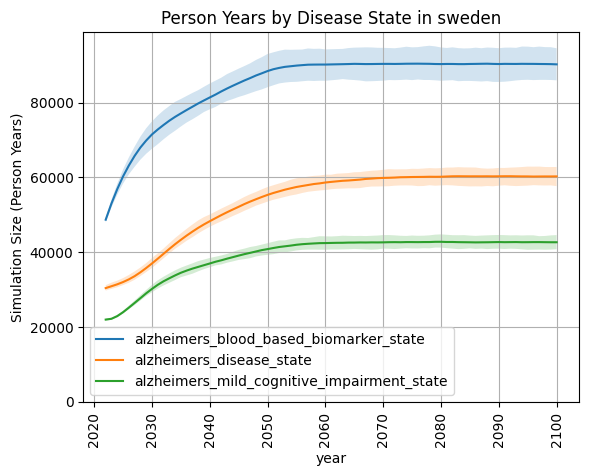

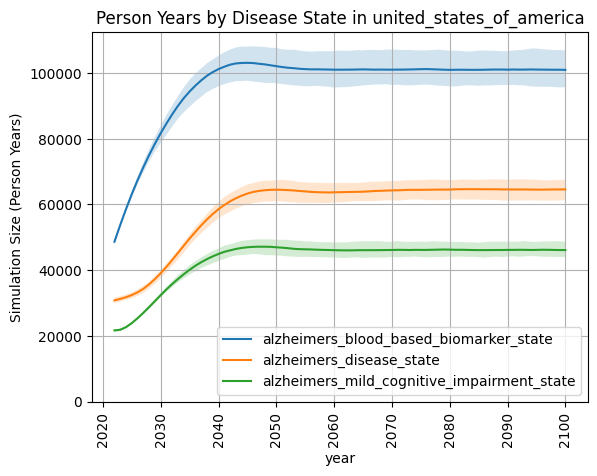

<Figure size 640x480 with 0 Axes>

In [ ]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()
    plt.figure()